# VAE on MNIST

参考资料：https://avandekleut.github.io/vae/  
https://hunterheidenreich.com/posts/modern-variational-autoencoder-in-pytorch/#where-does-this-kl-divergence-come-from

## Introduction

The last decade has seen a surge in generative modeling research, including Generative Adversarial Networks (GANs), normalizing flows, and diffusion models. Despite the advancements, Variational Autoencoders (VAEs) remain a cornerstone in this field. A comprehensive understanding of VAEs is essential for anyone delving into generative AI, serving as a foundation for more complex models.

Many tutorials on VAEs exist, yet few leverage the latest PyTorch advancements, potentially missing out on optimization and numerical stability enhancements. This tutorial aims to fill that gap by demonstrating modern PyTorch techniques applied to VAEs, reducing the risk of issues like “NaN” loss.


What is a Variational Autoencoder?

The Variational Autoencoder (VAE) is a generative model first introduced in Auto-Encoding Variational Bayes by Kingma and Welling in 2013. To best understand VAEs, you should start with understanding why they were developed.


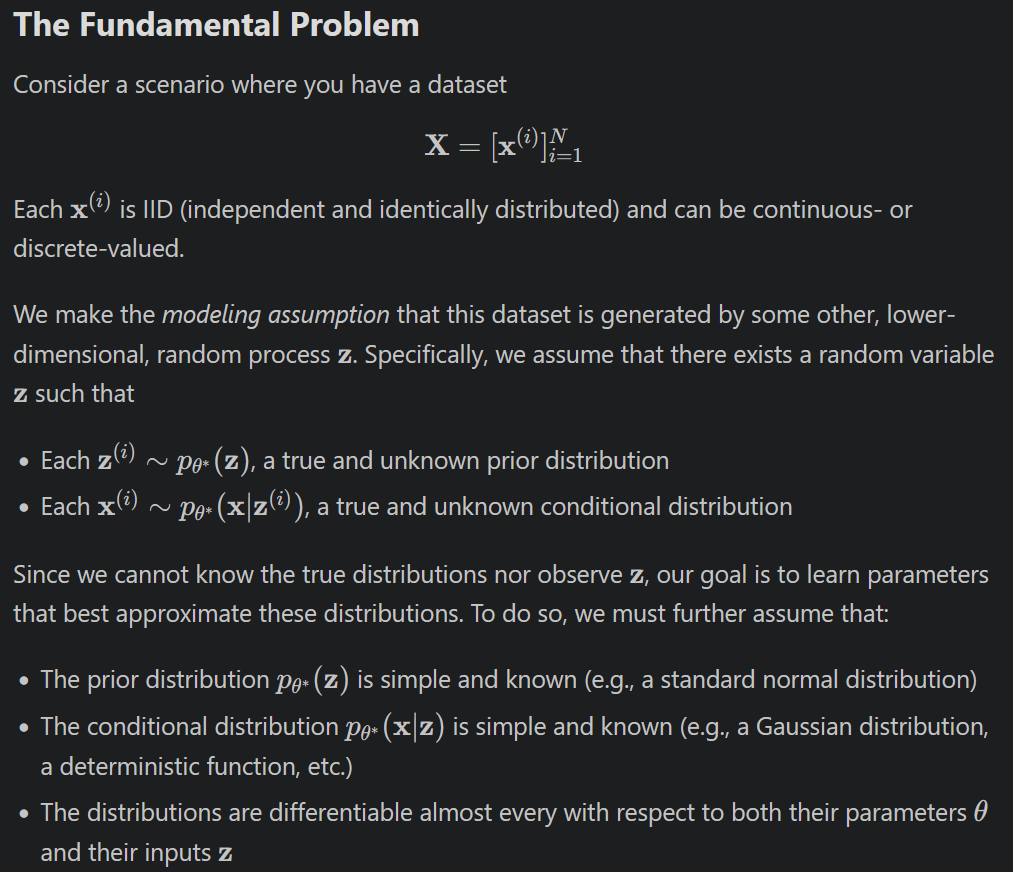

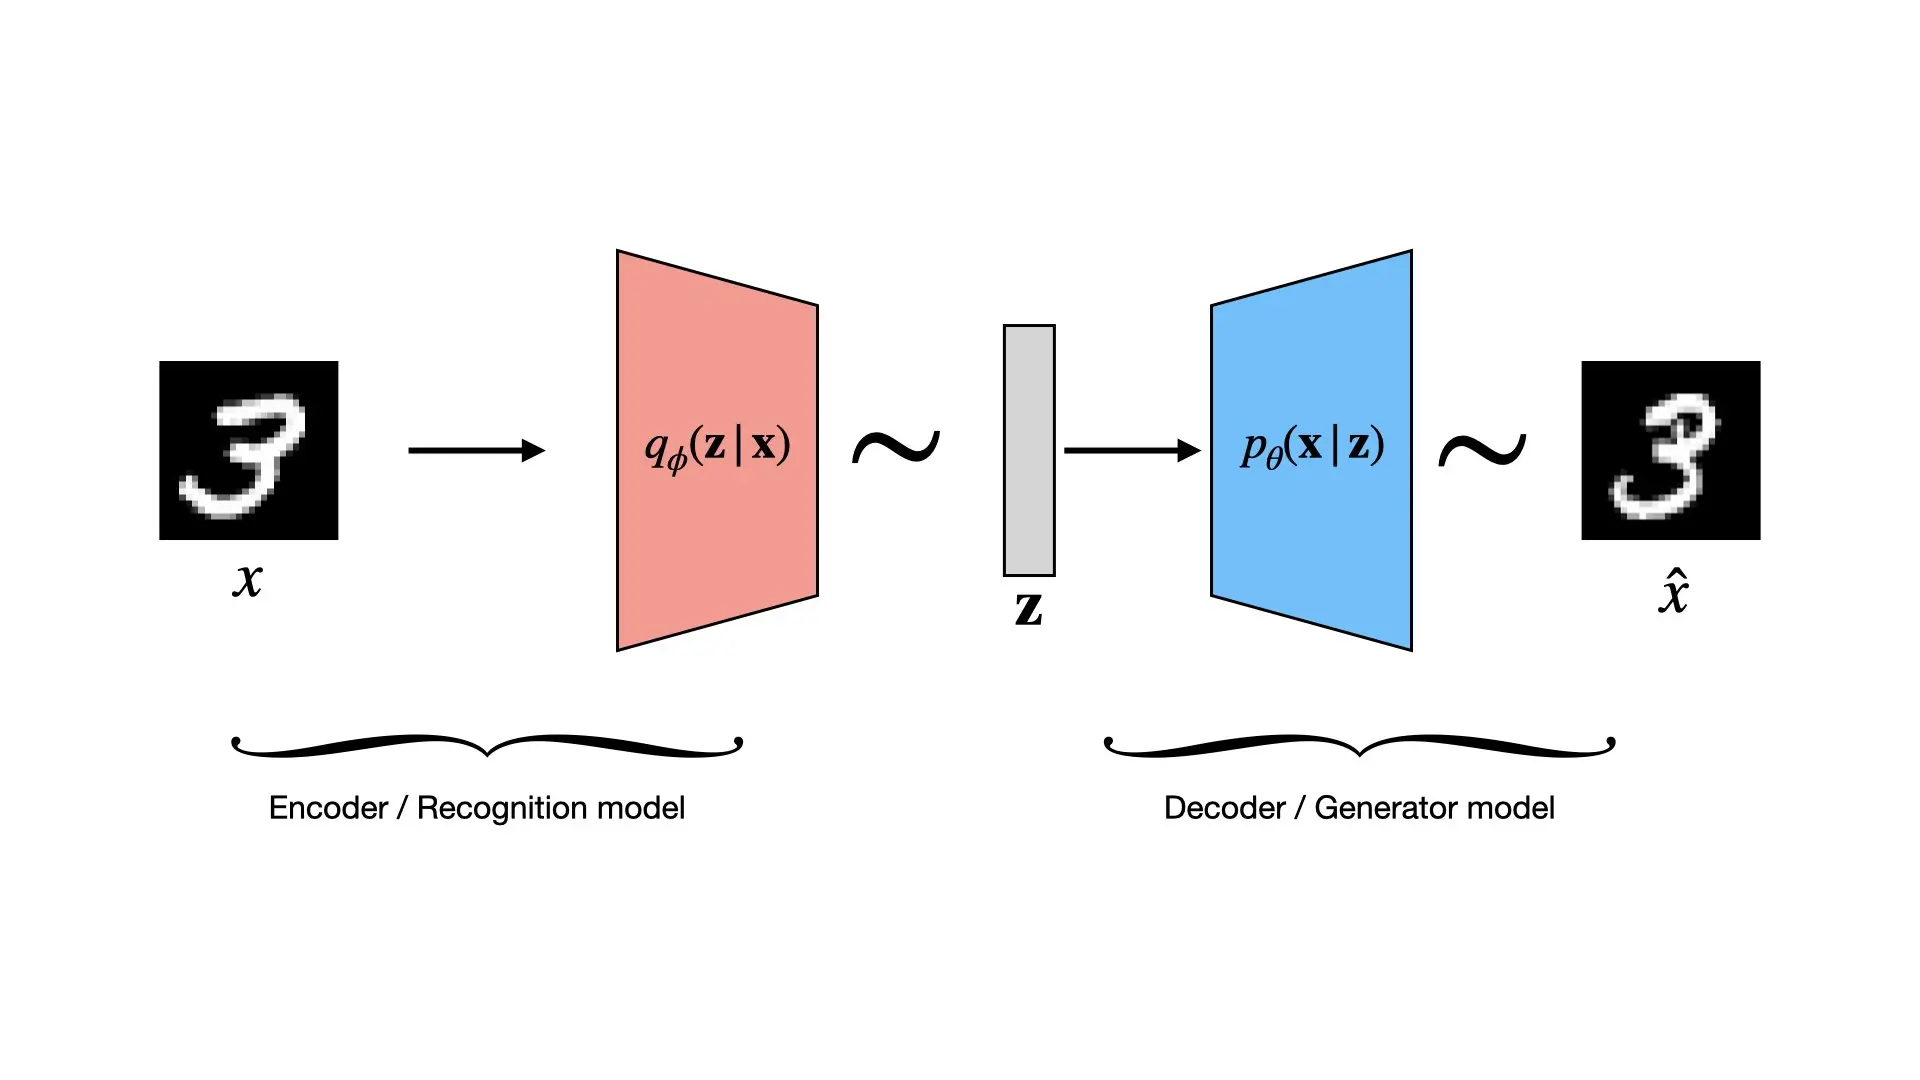

Uses of VAE:

        Dimensionality Reduction: VAEs can be used to learn a low-dimensional representation of high-dimensional data. This is useful for visualization, data compression, and feature extraction. In this way, VAEs are similar to PCA, t-SNE, and UMAP, or autoencoders. Another way is to think of VAEs as a tool for identifying the intrinsic dimensionality of the data.
        Imputation: VAEs can be used to fill in missing data. This is useful for data preprocessing and data augmentation. Image in-painting, de-noising, and super-resolution are all examples of imputation.
        Generation: VAEs can be used to generate new data. This is useful for data augmentation, data synthesis, and generative modeling. Image generation, text generation, and music generation are all examples of generation. Additionally, if we are mimicking a physical process, we may also be interested in the learned parameters of the model.

# Implementation

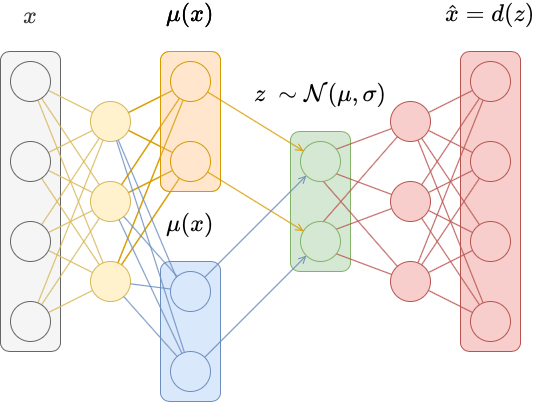

In [1]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200

device = 'cuda' if torch.cuda.is_available() else 'cpu'

class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 784)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))

class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1).sum()*1/2 # KLD 
        return z

class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

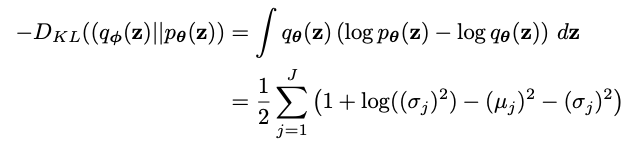

model is on: cuda:0



(dot.exe:28092): Pango-WARNING **: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


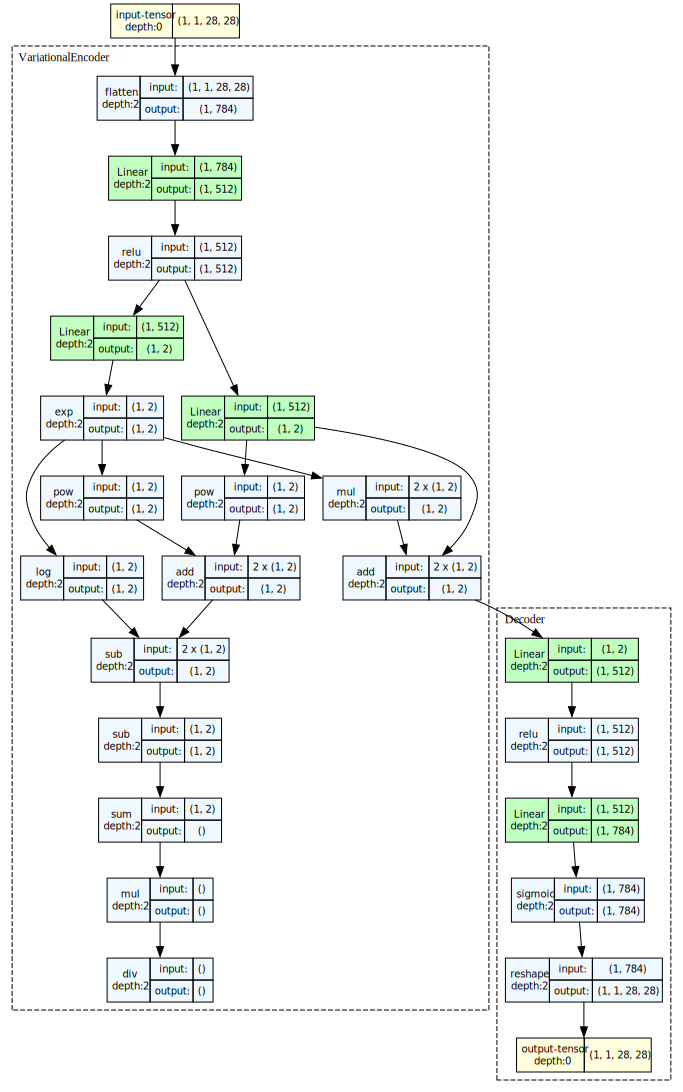

In [2]:
from torchview import draw_graph

device =torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VariationalAutoencoder(latent_dims = 2).to(device)

device = next(model.parameters()).device
print('model is on:', device)

model_graph = draw_graph(model, input_size=(1, 1, 28, 28), expand_nested=True) # device='meta', 
model_graph.visual_graph

In [3]:
from tqdm import tqdm

def train(model, data, epochs=20):
    opt = torch.optim.Adam(model.parameters())
    for epoch in tqdm(range(epochs)):
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            z = model.encoder(x)
            x_hat = model.decoder(z)
            loss = ((x - x_hat)**2).sum() + model.encoder.kl # VAE loss = MSE + KLD. FUTURE: with weights
            loss.backward()
            opt.step()
    return model

data = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('../data',
               transform=torchvision.transforms.ToTensor(),
               download=True),
        batch_size=128,
        shuffle=True)

model = train(model, data, epochs=20)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [04:13<00:00, 12.69s/it]


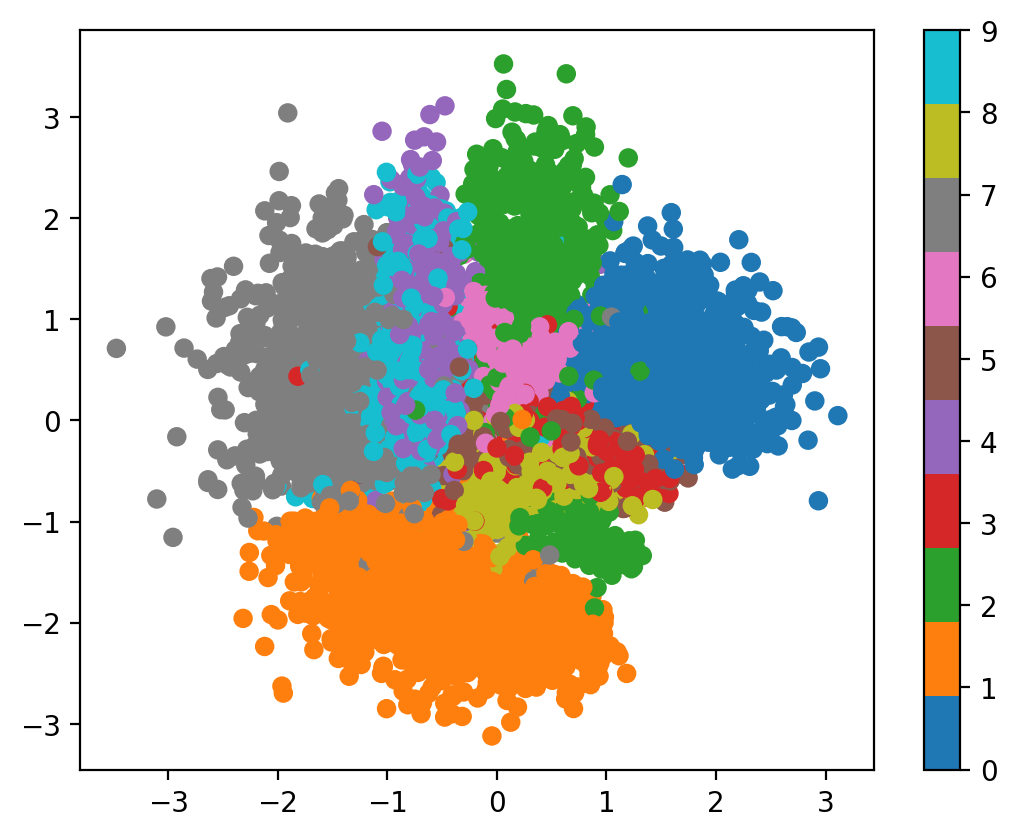

In [4]:
def plot_latent(model, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = model.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break

plot_latent(model, data)

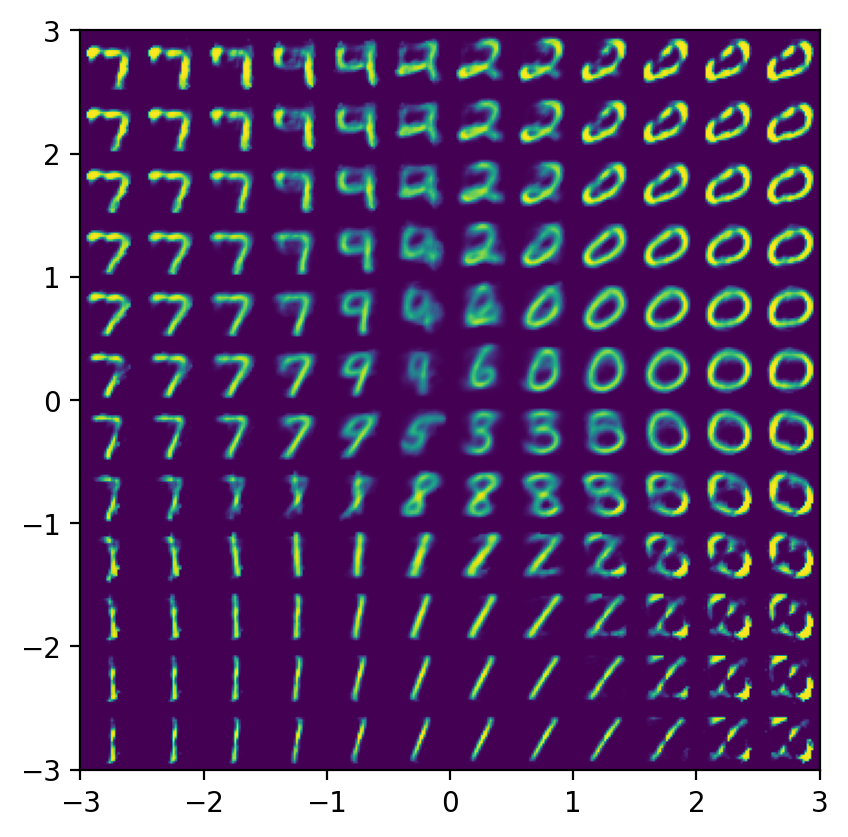

In [17]:
def plot_reconstructed(model, r0=(-3, 3), r1=(-3, 3), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = model.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

plot_reconstructed(model)

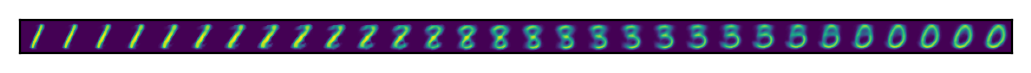

In [33]:
def interpolate(autoencoder, x_1, x_2, n=12):
    z_1 = autoencoder.encoder(x_1)
    z_2 = autoencoder.encoder(x_2)
    z = torch.stack([z_1 + (z_2 - z_1)*t for t in np.linspace(0, 1, n)])
    interpolate_list = autoencoder.decoder(z)
    interpolate_list = interpolate_list.to('cpu').detach().numpy()

    w = 28
    img = np.zeros((w, n*w))
    for i, x_hat in enumerate(interpolate_list):
        img[:, i*w:(i+1)*w] = x_hat.reshape(28, 28)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

x, y = next(data.__iter__()) # .__iter__().next() # hack to grab a batch
x_1 = x[y == 1][1].to(device) # find a 1
x_2 = x[y == 0][1].to(device) # find a 0

interpolate(model, x_1, x_2, n=30)

## Alternative Implementation 

https://hunterheidenreich.com/posts/modern-variational-autoencoder-in-pytorch/

```
        x = self.encoder(x)
        mu, logvar = torch.chunk(x, 2, dim=-1)
        scale = self.softplus(logvar) + eps
        scale_tril = torch.diag_embed(scale)
        
        return torch.distributions.MultivariateNormal(mu, scale_tril=scale_tril)
```

In [7]:
# The torch.chunk function in PyTorch is used to split a tensor into a specified number of chunks along a given dimension.
x = torch.tensor([1,2,3,4,5,6,7,8])
mu, logvar = torch.chunk(x, 2, dim=-1) 
mu, logvar

(tensor([1, 2, 3, 4]), tensor([5, 6, 7, 8]))

In [8]:
import torch.nn.functional as F
scale = F.softplus(logvar.float()) 
scale

tensor([5.0067, 6.0025, 7.0009, 8.0003])

SoftPlus:  log(1+exp(x))  
SoftPlus is a smooth approximation to the ReLU function and can be used to constrain the output of a machine to always be positive.

In [9]:
scale_tril = torch.diag_embed(scale) 
scale_tril

tensor([[5.0067, 0.0000, 0.0000, 0.0000],
        [0.0000, 6.0025, 0.0000, 0.0000],
        [0.0000, 0.0000, 7.0009, 0.0000],
        [0.0000, 0.0000, 0.0000, 8.0003]])

diag_embed: Creates a tensor whose diagonals of certain 2D planes (specified by dim1 and dim2) are filled by input. 创建对角阵

In [10]:
d = torch.distributions.MultivariateNormal(mu, scale_tril=scale_tril) # 使用 scale_tril 会更高效使用 scale_tril 会更高效

In [11]:
d.loc # mean vec

tensor([1, 2, 3, 4])

In [12]:
d.covariance_matrix # cov

tensor([[25.0672,  0.0000,  0.0000,  0.0000],
        [ 0.0000, 36.0297,  0.0000,  0.0000],
        [ 0.0000,  0.0000, 49.0128,  0.0000],
        [ 0.0000,  0.0000,  0.0000, 64.0054]])